# Machine Learning on Sequential Data

**OBJECTIVES**:

- Use pandas to access time series data
- Use `statsmodels` to model time series `ARIMA` and `SARIMA` models.
- Use `pdarima` to determine parameters for ARIMA models.
- Use `sktime` to build and model time series
- Examine `tsfresh` to generate features for time series analysis

In [112]:
#!pip install pmdarima

In [113]:
import pandas_datareader as pdr

In [115]:
pdr.get_data_yahoo('NFLX').head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-09-24,104.000000,96.779999,97.110001,103.760002,21274500,103.760002
2015-09-25,105.449997,101.570000,105.300003,102.239998,19066600,102.239998
2015-09-28,103.330002,97.839996,101.570000,99.470001,17026600,99.470001
2015-09-29,100.629997,96.849998,99.629997,98.349998,17405900,98.349998
2015-09-30,103.459999,99.050003,99.910004,103.260002,17027600,103.260002


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas_datareader as pdr

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.datasets import load_lynx, load_airpassengers, load_wineind

### Time Series Datasets

In [5]:
lynx, air, wine = load_lynx(), load_airpassengers(as_series=True), load_wineind()

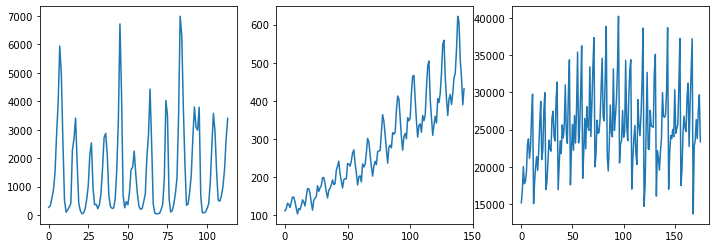

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
ax[0].plot(lynx)
ax[1].plot(air)
ax[2].plot(wine);

In [7]:
airdf = pd.DataFrame(air, columns = ['passengers'])

In [10]:
airdf.head(4)

,passengers
0,112.0
1,118.0
2,132.0
3,129.0


In [12]:
#find the first difference
airdf.diff(2).head(4)

,passengers
0,NaN
1,NaN
2,20.0
3,11.0


In [15]:
#add to column in DataFrame
airdf['first_diff'] = airdf.diff(1)

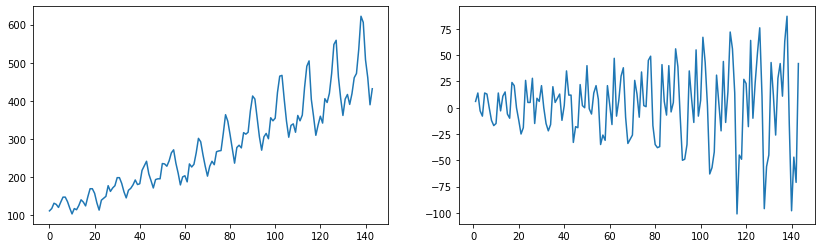

In [16]:
#plot the series and its first difference
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].plot(airdf['passengers'])
ax[1].plot(airdf['first_diff'])

In [17]:
airdf.head()

,passengers,first_diff
0,112.0,NaN
1,118.0,6.0
2,132.0,14.0
3,129.0,-3.0
4,121.0,-8.0


In [20]:
#shift the time-series
airdf['1dshift'] = airdf['passengers'].shift()
airdf['2dshift'] = airdf['passengers'].shift(2)

In [21]:
airdf.head()

,passengers,first_diff,1dshift,2dshift
0,112.0,NaN,NaN,NaN
1,118.0,6.0,112.0,NaN
2,132.0,14.0,118.0,112.0
3,129.0,-3.0,132.0,118.0
4,121.0,-8.0,129.0,132.0


<AxesSubplot:xlabel='passengers', ylabel='1dshift'>

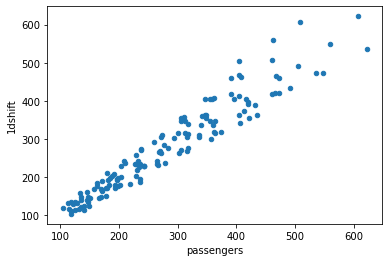

In [22]:
#plot the time series against its shifted data
airdf.plot(x = 'passengers', y = '1dshift', kind = 'scatter')

In [23]:
#shift the differences
airdf['shift_diff'] = airdf['first_diff'].shift()

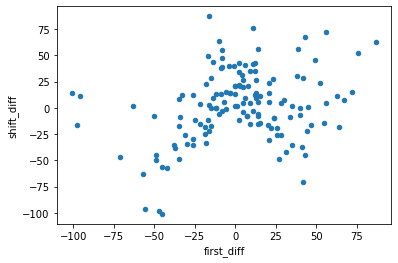

In [24]:
#plot diff agains its shift
airdf.plot(x = 'first_diff', y = 'shift_diff', kind = 'scatter');

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

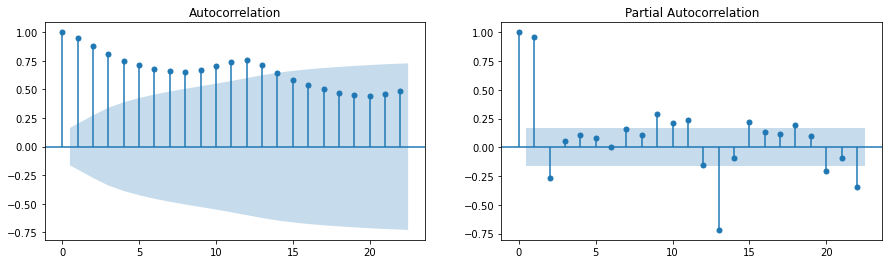

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
plot_acf(airdf['passengers'], ax = ax[0])
plot_pacf(airdf['passengers'], ax = ax[1]);

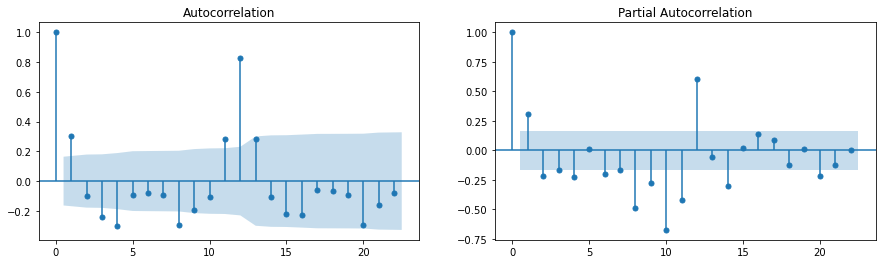

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
plot_acf(airdf['passengers'].diff().dropna(), ax = ax[0])
plot_pacf(airdf['passengers'].diff().dropna(), ax = ax[1]);

### Stationarity

> *In mathematics and statistics, a stationary process (or a strict/strictly stationary process or strong/strongly stationary process) is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.* -- Wikipedia

We can test for this with the **Augmented Dickey Fuller Test**; here we have

$$H_0 = \text{not stationary}$$
$$H_1 = \text{stationary}$$

In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
adfuller(airdf['passengers'])

(0.815368879206047,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

In [34]:
adfuller(airdf['passengers'].diff().dropna())

(-2.8292668241700056,
 0.054213290283824704,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854084)

In [42]:
adfuller(airdf['passengers'].diff(2).dropna())

(-2.9616951355554217,
 0.03862975767698862,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 985.7309222414162)

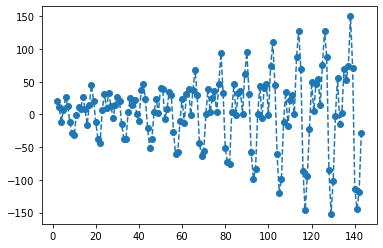

In [38]:
plt.plot(airdf['passengers'].diff(2).dropna(), '--o')

### Statsmodels Arima

In [43]:
airdf['passengers'].rolling(window = 2).mean().head(4)

0      NaN
1    115.0
2    125.0
3    130.5
Name: passengers, dtype: float64

In [44]:
arima = sm.tsa.arima.ARIMA(endog = airdf['passengers'], order = (1,0,0)).fit()

In [45]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  144
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -711.090
Date:                Tue, 22 Sep 2020   AIC                           1428.181
Time:                        20:32:44   BIC                           1437.090
Sample:                             0   HQIC                          1431.801
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.2943     66.403      4.221      0.000     150.146     410.442
ar.L1          0.9645      0.019     51.535      0.000       0.928       1.001
sigma2      1118.5409    122.133      9.158      0.000     879.164    1357.918
===================================================================================
Ljung-Box (Q):                      439.61   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.00   Prob(JB):                         0.67
Heteroskedasticity (H):               7.92   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
arima.forecast(steps = 10)

144    426.621813
145    421.434291
146    416.430674
147    411.604442
148    406.949307
149    402.459204
150    398.128281
151    393.950896
152    389.921606
153    386.035159
dtype: float64

In [47]:
airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   passengers  144 non-null    float64
 1   first_diff  143 non-null    float64
 2   1dshift     143 non-null    float64
 3   2dshift     142 non-null    float64
 4   shift_diff  142 non-null    float64
dtypes: float64(5)
memory usage: 5.8 KB


In [49]:
Xtr = airdf.iloc[:-15, 0]
Xts = airdf.iloc[-15:, 0]

In [50]:
from statsmodels.tsa.api import ARIMA

In [51]:
arima = ARIMA(Xtr, order = (2, 1, 1)).fit()

In [52]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  128
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -596.063
Method:                       css-mle   S.D. of innovations             25.042
Date:                Tue, 22 Sep 2020   AIC                           1202.125
Time:                        20:35:28   BIC                           1216.386
Sample:                             1   HQIC                          1207.919
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5632      0.144     17.844      0.000       2.282       2.845
ar.L1.D.passengers     1.0928      0.078     13.921      0.000       0.939       1.247
ar.L2.D.passengers    -0.5036      0.082     -6.162      0.000      -0.664      -0.343
ma.L1.D.passengers    -0.9999      0.027    -36.381      0.000      -1.054      -0.946
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0850           -0.8991j            1.4092           -0.1101
AR.2            1.0850           +0.8991j            1.4092            0.1101
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [53]:
forecast = arima.forecast(15)[0]

In [54]:
forecast

array([399.71482509, 379.95264355, 391.27830761, 414.65981152,
       435.5608771 , 447.68023476, 451.45195639, 450.52358385,
       448.66259522, 448.14930163, 449.57842704, 452.45157558,
       455.92460544, 459.32601211, 462.34706094])

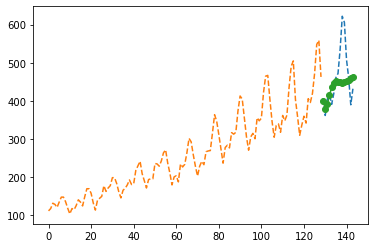

In [56]:
plt.plot(Xts, '--')
plt.plot(Xtr, '--')
plt.plot(Xts.index, forecast, '-o')

### pmdarima

In [58]:
import pmdarima as pm

In [59]:
stepwise_fit = pm.auto_arima(Xtr, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=879.138, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=881.901, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=877.920, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=878.938, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=876.775, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=878.101, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=877.993, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=877.677, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=877.710, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=879.650, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=878.414, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.092 seconds


In [60]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  129
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -436.388
Date:                            Tue, 22 Sep 2020   AIC                            876.775
Time:                                    20:41:10   BIC                            882.282
Sample:                                         0   HQIC                           879.011
                                            - 129                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2435      0.090     -2.703      0.007      -0.420      -0.067
sigma2       108.3673     13.291      8.154      0.000      82.318     134.417
===================================================================================
Ljung-Box (Q):                       43.25   Jarque-Bera (JB):                 0.74
Prob(Q):                              0.33   Prob(JB):                         0.69
Heteroskedasticity (H):               1.40   Skew:                            -0.04
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

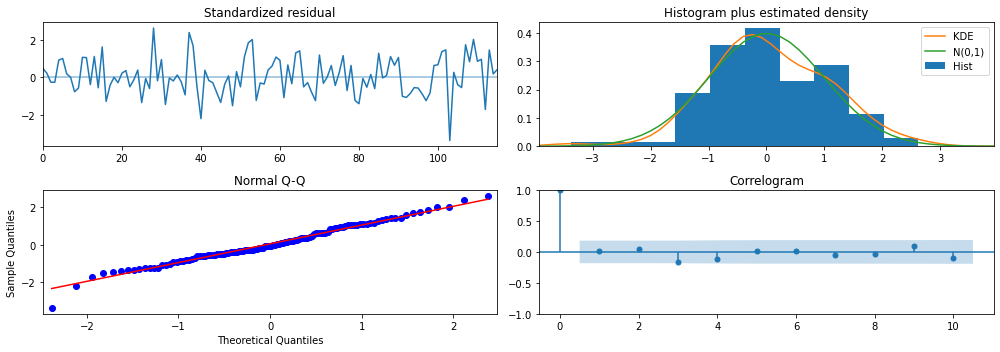

In [61]:
stepwise_fit.plot_diagnostics(figsize = (14, 5));
plt.tight_layout();

### `sktime`

Many of these examples come from the documentation on the `sktime` library [here](https://github.com/alan-turing-institute/sktime).  There is a wealth of additional tasks we can use the library for outside of forecasting and I encourage you to examine these examples.

In [ ]:
#!pip install sktime

In [62]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys

In [63]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y)

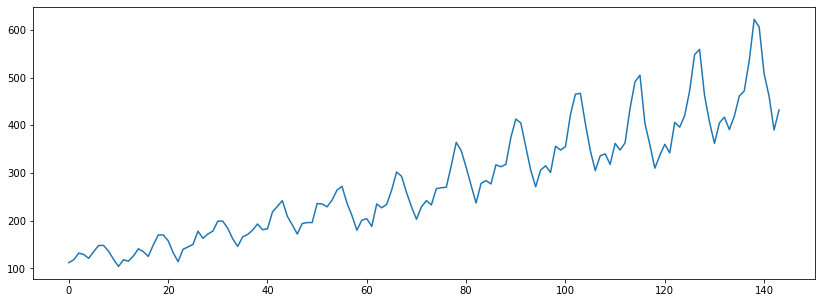

In [64]:
plt.figure(figsize = (14, 5))
plt.plot(y)

In [65]:
fh = np.arange(1, len(y_test) + 1)  # forecasting horizon
forecaster = ThetaForecaster(sp=12)  # monthly seasonal periodicity
forecaster.fit(y_train)

ThetaForecaster(sp=12)

In [66]:
y_pred = forecaster.predict(fh)
smape_loss(y_test, y_pred)

0.0866146913565924

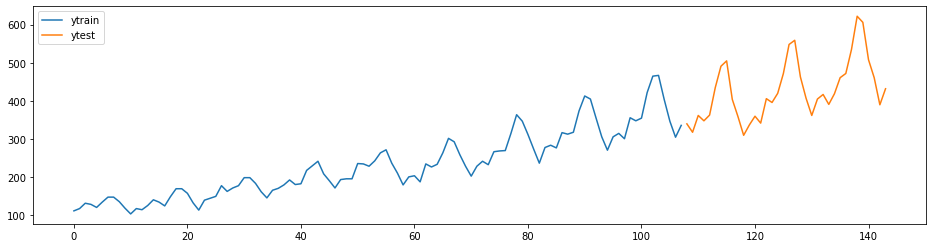

In [68]:
y_train, y_test = temporal_train_test_split(y, test_size = 36)
plot_ys(y_train, y_test, labels = ['ytrain', 'ytest']);

0.23195770387951434

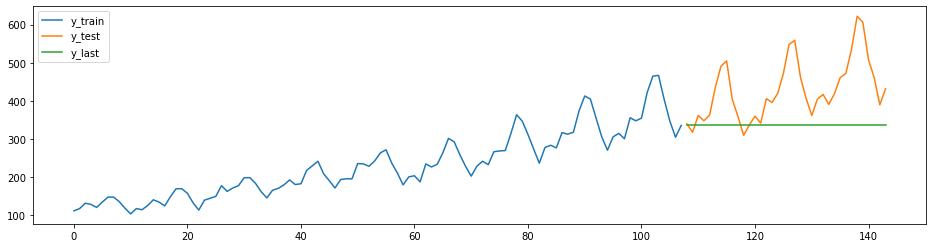

In [69]:
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_last = forecaster.predict(fh)
plot_ys(y_train, y_test, y_last, labels=["y_train", "y_test", "y_last"]);
smape_loss(y_last, y_test)

0.5805935443500755

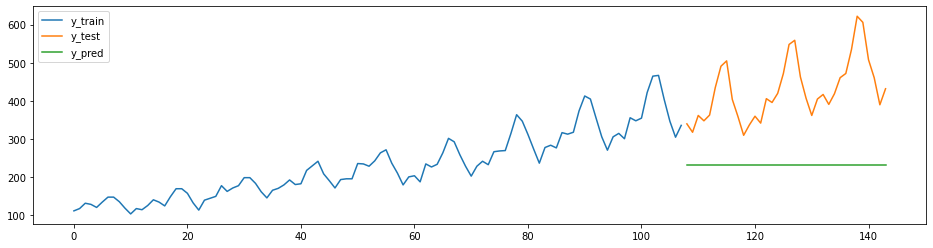

In [70]:
forecaster = NaiveForecaster(strategy="mean")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

In [71]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [72]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor

In [73]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


0.14008272913734346

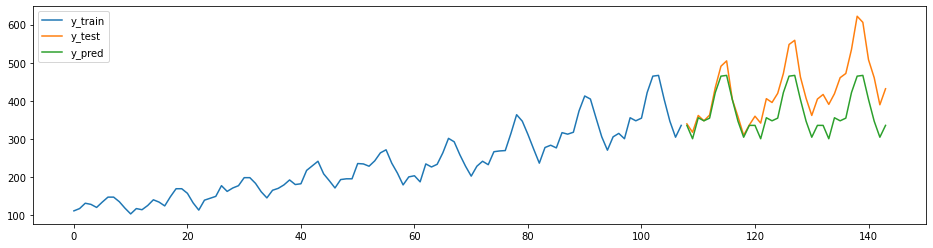

In [74]:
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [75]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
cv = SlidingWindowSplitter(window_length=10, start_with_window=True)
for input_window, output_window in cv.split(y_train.iloc[:20]):
    print(input_window, output_window)

[0 1 2 3 4 5 6 7 8 9] [10]
[ 1  2  3  4  5  6  7  8  9 10] [11]
[ 2  3  4  5  6  7  8  9 10 11] [12]
[ 3  4  5  6  7  8  9 10 11 12] [13]
[ 4  5  6  7  8  9 10 11 12 13] [14]
[ 5  6  7  8  9 10 11 12 13 14] [15]
[ 6  7  8  9 10 11 12 13 14 15] [16]
[ 7  8  9 10 11 12 13 14 15 16] [17]
[ 8  9 10 11 12 13 14 15 16 17] [18]
[ 9 10 11 12 13 14 15 16 17 18] [19]


0.05106126665215278

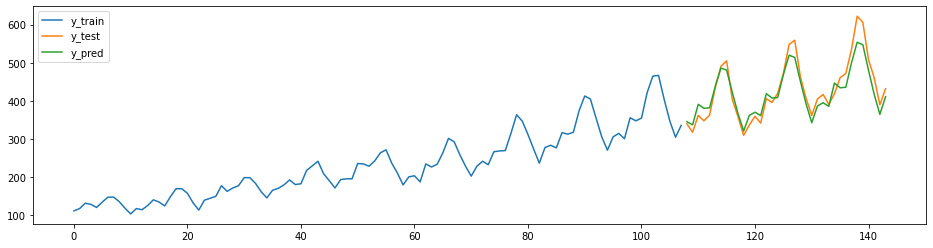

In [76]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

0.04117062368222738

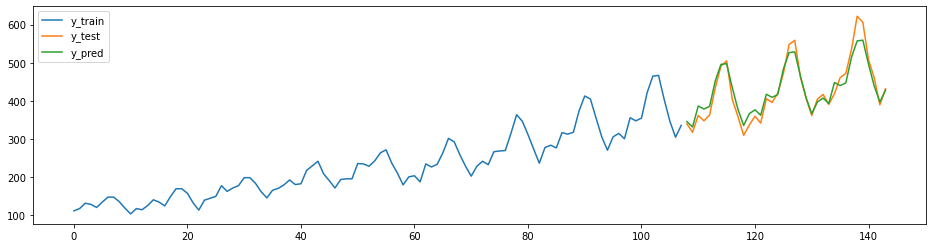

In [77]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

0.07021244478214374

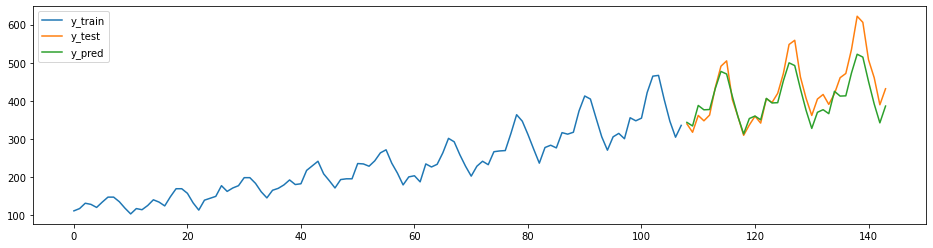

In [78]:
from sktime.forecasting.compose import EnsembleForecaster
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=12)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=12))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [79]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV

forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [5, 10, 15]}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

0.14187443909112035

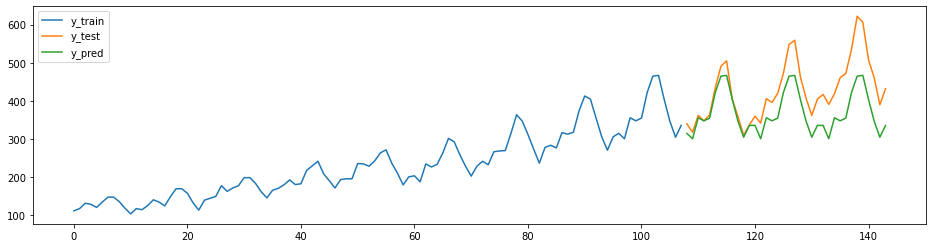

In [80]:
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [81]:
gscv.best_params_

{'window_length': 15}

In [83]:
from sklearn.ensemble import RandomForestRegressor

In [84]:
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.compose import RecursiveRegressionForecaster

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [5,10,15,20,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = RecursiveRegressionForecaster(regressor, window_length=15)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

0.12742386002516992

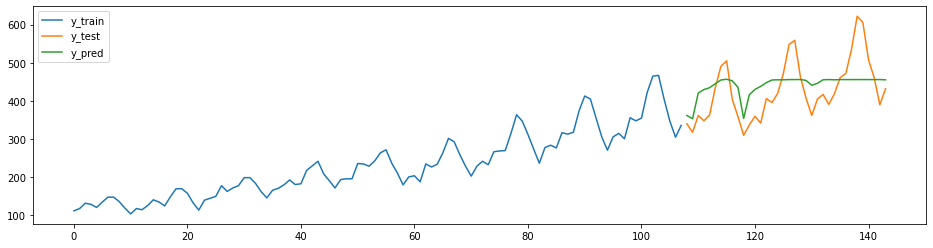

In [85]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

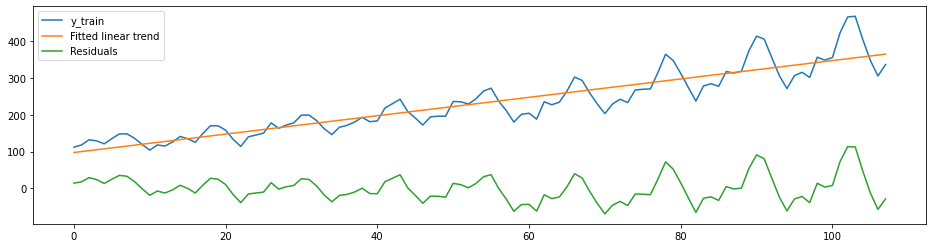

In [86]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.single_series.detrend import Detrender

# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_ys(y_train, y_pred, yt, labels=["y_train", "Fitted linear trend", "Residuals"]);

0.05465417536343111

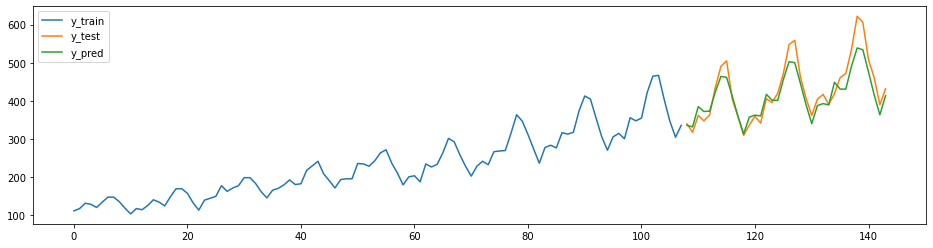

In [87]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.single_series.detrend import Deseasonalizer

forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive"))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [ ]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
cv = SlidingWindowSplitter(fh=1)
y_pred = forecaster.update_predict(y_test, cv)
smape_loss(y_test, y_pred)
plot_ys(y_train, y_test, y_pred);

In [ ]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

fig, ax = plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(y_pred.index, pred_ints["lower"], pred_ints["upper"], alpha=0.2, color="green", label=f"{1 - alpha}% prediction intervals")
plt.legend();

### Facebook `prophet`

In [ ]:
#!pip install pystan
#!pip install fbprophet
#!pip install plotly

In [88]:
from fbprophet import Prophet

In [89]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv')

In [90]:
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [91]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [92]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [93]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.214006,7.422133,8.882787
3266,2017-01-16,8.539078,7.728878,9.216637
3267,2017-01-17,8.326518,7.600238,9.061689
3268,2017-01-18,8.159179,7.435906,8.831357
3269,2017-01-19,8.171119,7.440436,8.880278


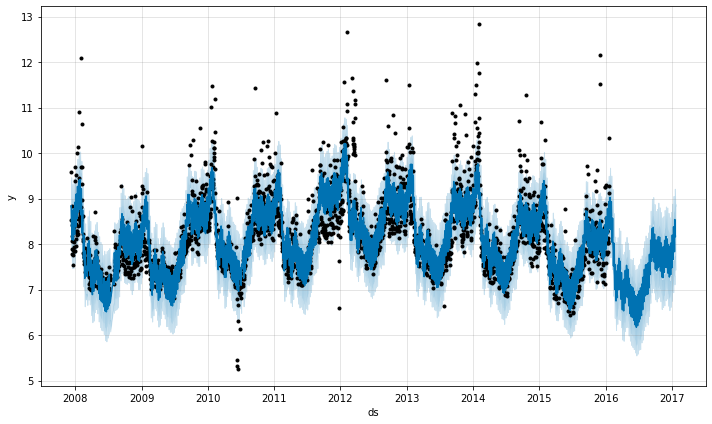

In [94]:
fig1 = m.plot(forecast)

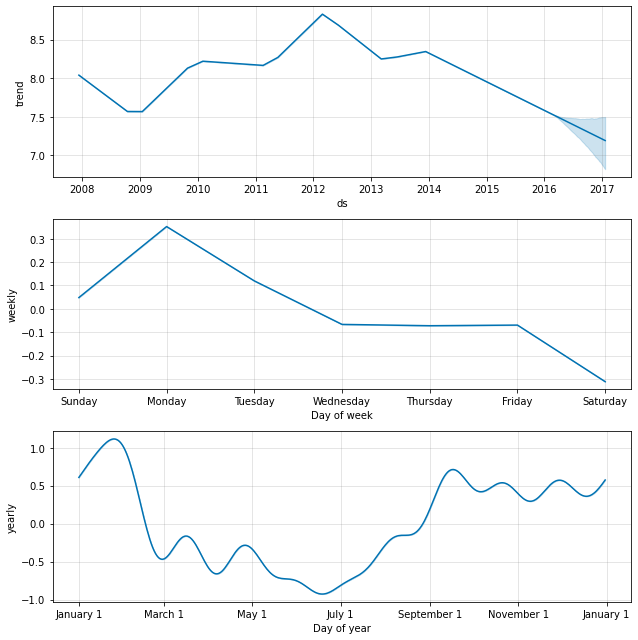

In [95]:
fig2 = m.plot_components(forecast)

### `tsfresh`

<center>
<img src = https://github.com/blue-yonder/tsfresh/raw/main/docs/images/introduction_ts_exa_features.png />
</center>

In [ ]:
#!pip install tsfresh

In [96]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [97]:
timeseries.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


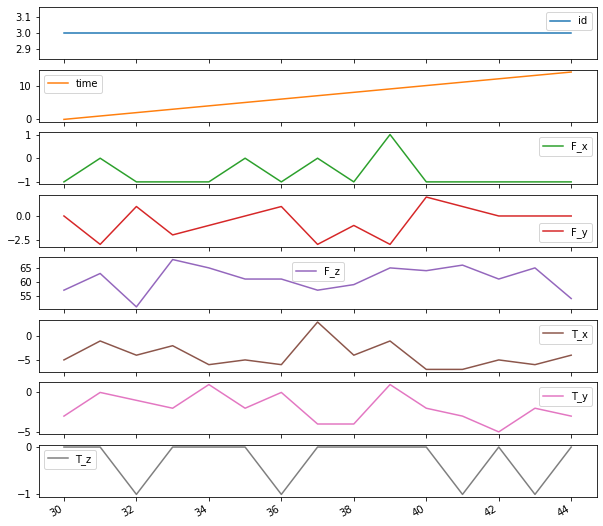

In [98]:
timeseries[timeseries['id'] == 3].plot(subplots=True, sharex=True, figsize=(10,10));

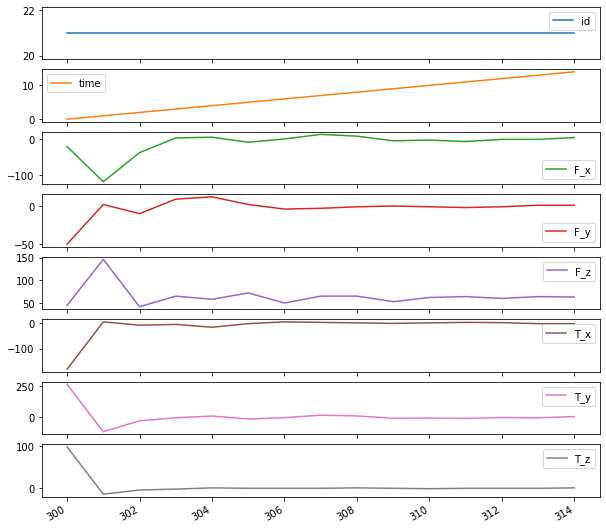

In [99]:
timeseries[timeseries['id'] == 21].plot(subplots=True, figsize=(10,10));

In [100]:
from tsfresh import extract_features
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 38/38 [00:03<00:00,  9.89it/s]


### Using with a Pipeline

In [101]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from tsfresh.examples import load_robot_execution_failures
from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh.utilities.dataframe_functions import impute

In [102]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures

df_ts, y = load_robot_execution_failures()

In [103]:
X = pd.DataFrame(index=y.index)

# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [104]:
ppl = Pipeline([
        ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='time')),
        ('classifier', RandomForestClassifier())
      ])

In [105]:
ppl.set_params(augmenter__timeseries_container=df_ts);

In [106]:
ppl.fit(X_train, y_train)

Feature Extraction: 100%|██████████| 40/40 [00:02<00:00, 13.47it/s]
/Users/jacobkoehler/opt/anaconda3/envs/for_ds/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


Pipeline(steps=[('augmenter',
                 RelevantFeatureAugmenter(column_id='id', column_sort='time',
                                          timeseries_container=      id  time  F_x  F_y  F_z  T_x  T_y  T_z
0      1     0   -1   -1   63   -3   -1    0
1      1     1    0    0   62   -3   -1    0
2      1     2   -1   -1   61   -3    0    0
3      1     3   -1   -1   63   -2   -1    0
4      1     4   -1   -1   63   -3   -1    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[1320 rows x 8 columns])),
                ('classifier', RandomForestClassifier())])

In [107]:
y_pred = ppl.predict(X_test)
print(classification_report(y_test, y_pred))

Feature Extraction: 100%|██████████| 33/33 [00:01<00:00, 24.64it/s]


              precision    recall  f1-score   support

       False       1.00      1.00      1.00        15
        True       1.00      1.00      1.00         7

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



In [108]:
ppl.named_steps["augmenter"].feature_selector.relevant_features

['F_x__value_count__value_-1',
 'F_x__range_count__max_1__min_-1',
 'F_x__abs_energy',
 'F_y__abs_energy',
 'T_y__standard_deviation',
 'T_y__variance',
 'F_z__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"',
 'F_x__fft_coefficient__attr_"abs"__coeff_1',
 'T_y__fft_coefficient__attr_"abs"__coeff_1',
 'F_y__value_count__value_-1',
 'F_z__standard_deviation',
 'F_z__variance',
 'T_y__abs_energy',
 'F_x__autocorrelation__lag_1',
 'T_y__fft_coefficient__attr_"abs"__coeff_2',
 'F_x__partial_autocorrelation__lag_1',
 'F_x__variance',
 'F_x__standard_deviation',
 'F_x__ratio_value_number_to_time_series_length',
 'T_z__abs_energy',
 'T_y__fft_coefficient__attr_"abs"__coeff_4',
 'T_z__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"',
 'F_x__cid_ce__normalize_True',
 'F_z__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"',
 'T_x__ratio_value_number_to_time_series_length',
 'T_x__fft_coefficient__attr_"abs"__coeff_1',
 'F_x__lempel_ziv_complexity__bins_10